In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer



In [10]:
data = pd.read_csv("C:\\Users\\vigne\\Downloads\\titanic\\train.csv")

data = data.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)

print(data.isnull().sum())

data.describe()


Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
data['Age'] = data['Age'].fillna(data['Age'].median())
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

print(data.isnull().sum())


Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [12]:
le = LabelEncoder()

data['Sex'] = le.fit_transform(data['Sex'])
data['Embarked'] = le.fit_transform(data['Embarked'])
data['Pclass'] = le.fit_transform(data['Pclass'])

print(data.head())


   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0         0       2    1  22.0      1      0   7.2500         2
1         1       0    0  38.0      1      0  71.2833         0
2         1       2    0  26.0      0      0   7.9250         2
3         1       0    0  35.0      1      0  53.1000         2
4         0       2    1  35.0      0      0   8.0500         2


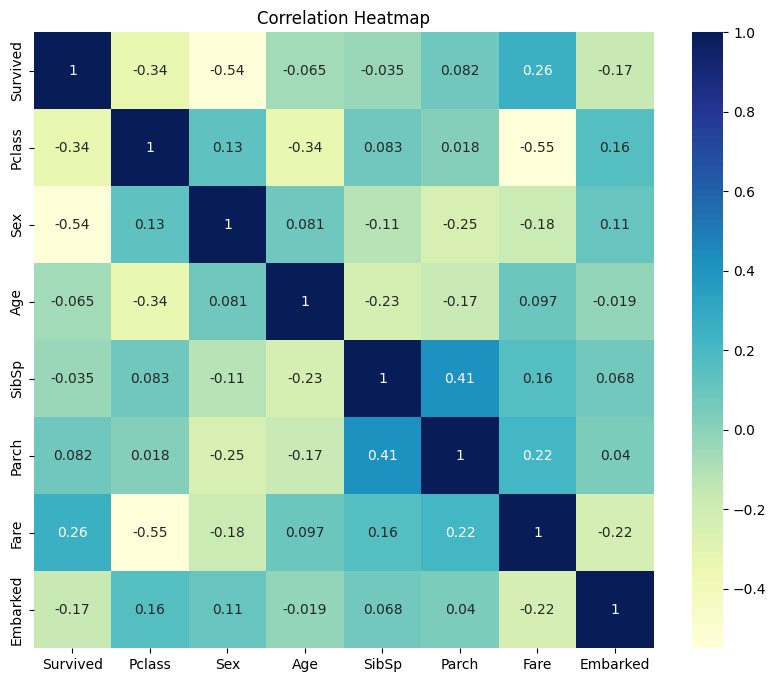

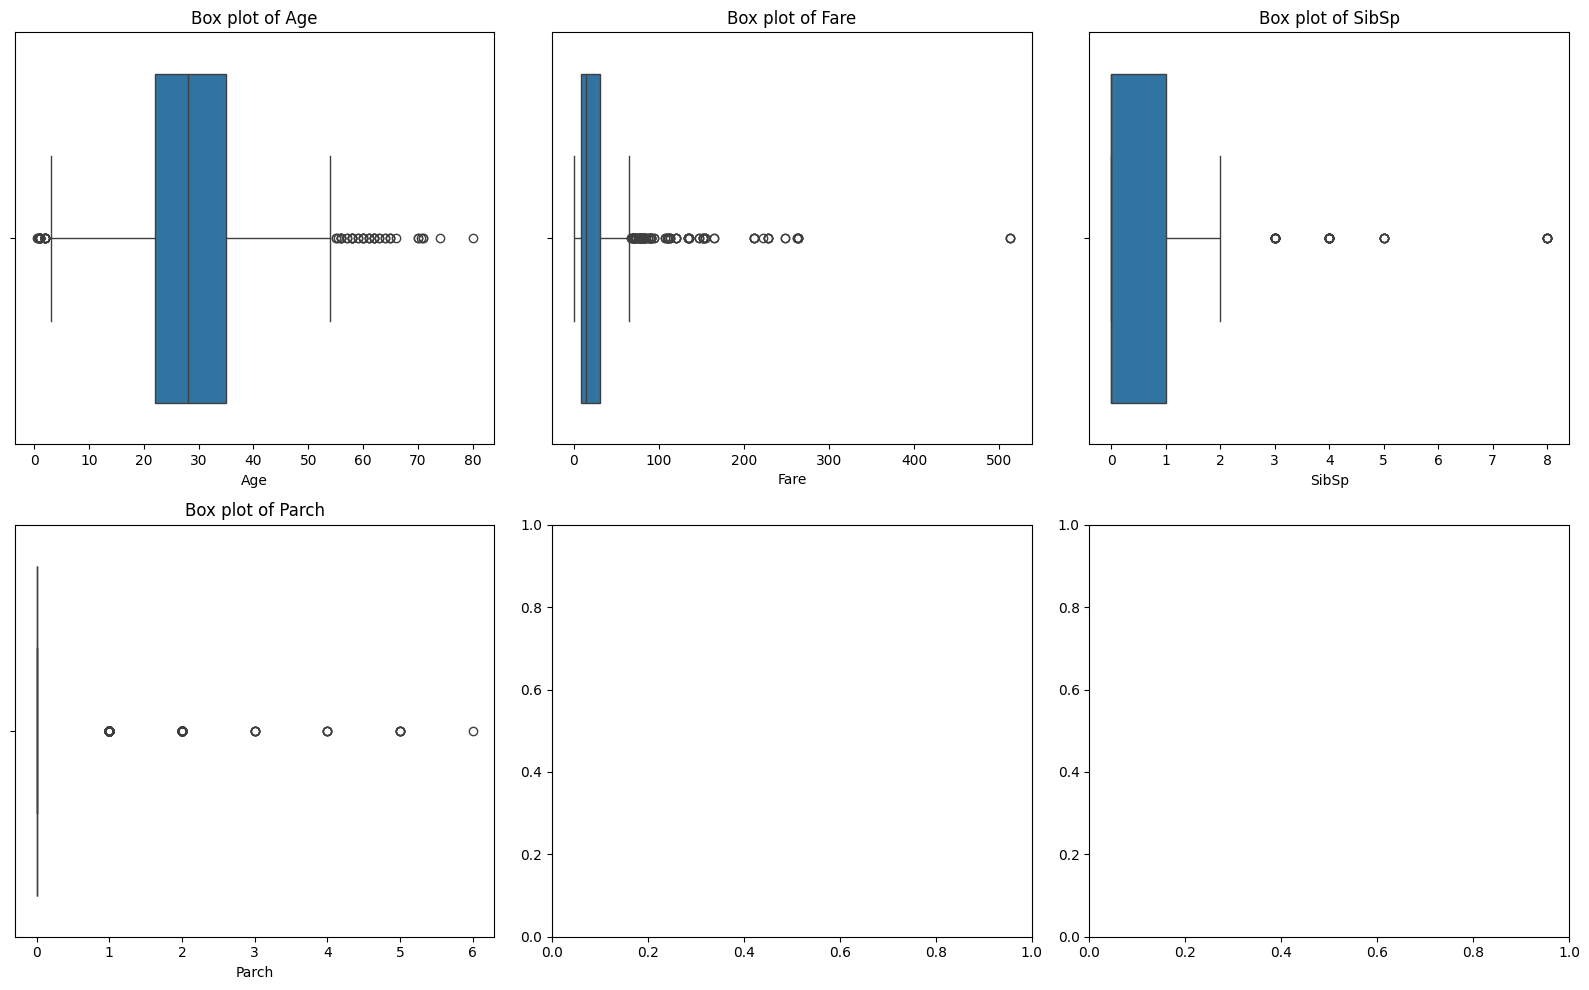

In [13]:
cor = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(cor, annot=True, cmap='YlGnBu')
plt.title('Correlation Heatmap')
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))  
axes = axes.flatten()

for ax, col in zip(axes, ['Age', 'Fare', 'SibSp', 'Parch']):
    sns.boxplot(x=data[col], ax=ax)
    ax.set_title(f'Box plot of {col}')

plt.tight_layout()
plt.show()


In [14]:
def detect_outliers(data, columns):
    for col in columns:
        z_scores = (data[col] - data[col].mean()) / data[col].std()
        z_scores.index = data.index  
        data = data[(z_scores.abs() <= 3)]
    return data

columns_to_clean = ['Age', 'Fare', 'SibSp', 'Parch']

data_clean = detect_outliers(data, columns_to_clean)

print(data_clean.shape)


(820, 8)


In [15]:
X = data_clean.drop(["Survived"], axis=1)
Y = data_clean["Survived"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Ridge Classifier": RidgeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier()
}

for name, model in models.items():
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    print(name)
    print("  Accuracy:", accuracy)
    print("  Confusion Matrix:\n", confusion_matrix(Y_test, y_pred))
    print("  Classification Report:\n", classification_report(Y_test, y_pred))


Logistic Regression
  Accuracy: 0.8048780487804879
  Confusion Matrix:
 [[89 16]
 [16 43]]
  Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       105
           1       0.73      0.73      0.73        59

    accuracy                           0.80       164
   macro avg       0.79      0.79      0.79       164
weighted avg       0.80      0.80      0.80       164

Decision Tree
  Accuracy: 0.7682926829268293
  Confusion Matrix:
 [[86 19]
 [19 40]]
  Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       105
           1       0.68      0.68      0.68        59

    accuracy                           0.77       164
   macro avg       0.75      0.75      0.75       164
weighted avg       0.77      0.77      0.77       164

Random Forest
  Accuracy: 0.8109756097560976
  Confusion Matrix:
 [[90 15]
 [16 43]]
  Classification Report:
        

In [16]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


best_model.fit(X_train, Y_train)
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print("Best Model Evaluation")
print("  Accuracy:", accuracy)
print("  Confusion Matrix:\n", confusion_matrix(Y_test, y_pred))
print("  Classification Report:\n", classification_report(Y_test, y_pred))


Best Model Evaluation
  Accuracy: 0.7987804878048781
  Confusion Matrix:
 [[91 14]
 [19 40]]
  Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.74      0.68      0.71        59

    accuracy                           0.80       164
   macro avg       0.78      0.77      0.78       164
weighted avg       0.80      0.80      0.80       164



In [17]:
def predict_survival():
    Pclass = int(input("Enter the Passenger Class (1, 2, or 3): "))
    Sex = input("Enter the Gender (male or female): ")
    Age = float(input("Enter the Age: "))
    SibSp = int(input("Enter the number of Siblings/Spouses aboard: "))
    Parch = int(input("Enter the number of Parents/Children aboard: "))
    Fare = float(input("Enter the Fare: "))
    Embarked = input("Enter the Embarkation point (C, Q, or S): ")

    input_df = pd.DataFrame({
        'Pclass': [Pclass],
        'Sex': [Sex],
        'Age': [Age],
        'SibSp': [SibSp],
        'Parch': [Parch],
        'Fare': [Fare],
        'Embarked': [Embarked]
    })

    print("\nInput Values:")
    print("----------------")
    print(input_df.to_string(index=False))

    # Encode categorical variables
    le = LabelEncoder()
    input_df['Sex'] = le.fit_transform(input_df['Sex'])
    input_df['Embarked'] = le.fit_transform(input_df['Embarked'])

    # Predict survival
    predicted_survival = best_model.predict(input_df)
    
    print("Predicted Survival (1 = Survived, 0 = Not Survived):", predicted_survival[0])

predict_survival()



Input Values:
----------------
 Pclass  Sex  Age  SibSp  Parch  Fare Embarked
      3 male 22.0      1      0  7.25        S
Predicted Survival (1 = Survived, 0 = Not Survived): 0
